mean reversion breakout strategy. will implement long and short seperately since implementation is very different in terms of margins with the broker. i think the sharpe is accurate, even higher in the constrained backtest. not sure what the capacity is

In [1]:
import util
import pandas as pd
import numpy as np
import twsq
from twsq.alpha import Alpha

In [47]:
import importlib
import util

importlib.reload(util)  # Reload the module to reflect changes

<module 'util' from 'c:\\Users\\joshu\\Documents\\Github\\Trading-Bot\\Live Trading\\util.py'>

In [2]:
layer1_coin_names = util.get_layer1_universe()

Fetched page 1 with 250 coins.
Fetched page 2 with 250 coins.
Fetched page 3 with 249 coins.


In [3]:
class MRBRShort(Alpha):
    def filter_universe(self, universe, window_needed, freq='1h'):
        """
        Filter the provided universe to include only symbols for which data exists.

        Parameters:
        -----------
        universe : list
            List of asset symbols.
        window_needed : int
            Minimum number of bars required.
        freq : str, optional
            Frequency of the bars (default '1h').

        Returns:
        --------
        list
            Filtered list of symbols.
        """
        valid_symbols = []
        for symbol in universe:
            try:
                bars = self.get_lastn_bars(symbol + '/USD', n=window_needed, freq=freq)
                if not bars.empty and len(bars) >= window_needed:
                    valid_symbols.append(symbol)
            except Exception as e:
                continue
        return valid_symbols
    """
    Mean reversion breakout strategy for short positions.
    """

    def prepare(self, universe=None, enter_lookback=1176, exit_lookback=12, dollar_exposure=1000):
        """
        Initialize strategy parameters.
        Parameters:
        -----------
        universe : list
            List of asset symbols to consider (e.g. ['BTC/USD', 'ETH/USD']).
        enter_lookback : int, optional
            Lookback period for the entry threshold.
        exit_lookback : int, optional
            Lookback period for the exit threshold.
        dollar_exposure : float, optional
            Total dollar exposure.
        """
        if universe is None:
            universe = util.get_layer1_universe()
        universe = [str(symbol).upper() for symbol in universe]
        self.enter_lookback = enter_lookback
        self.exit_lookback = exit_lookback
        self.dollar_exposure = dollar_exposure
        window_needed = max(self.enter_lookback, self.exit_lookback)
        self.universe = self.filter_universe(universe, window_needed)
        self.current_signals = {symbol: 0 for symbol in universe}
    
    def rebalance(self):
        """
        Compute mr breakout signals and rebalance positions.
        Dollar exposure is total exposure across all short positions.
        """
        target = {}
        signals = {}
        # Determine the number of bars needed from history.
        window_needed = max(self.enter_lookback, self.exit_lookback)
        
        # Compute signals for each asset.
        for symbol in self.universe:
            try:
                bars = self.get_lastn_bars(symbol + "/USD", n=window_needed, freq='1h')
                # Check if we have enough data.
                if bars.empty:
                    signal = 0
                else:
                    price_series = bars
                    ret = price_series['close'].pct_change()
                    enter_max = ret.iloc[-self.enter_lookback:].max()
                    exit_min = ret.iloc[-self.exit_lookback:].min()
                    # enter_max = price_series['close'].rolling(window=self.enter_lookback, min_periods = 1).max().iloc[-1]
                    # exit_min = price_series['close'].rolling(window=self.exit_lookback, min_periods = 1).min().iloc[-1]
                    current_price = ret.iloc[-1]
                    
                    # Determine signal based on the most recent value.
                    if not price_series.empty:
                        if current_price == enter_max:
                            signal = -1  # Enter short
                        elif current_price == exit_min:
                            signal = 0   # Exit short
                        else:
                            signal = self.current_signals[symbol]
                    else:
                        signal = 0
            except Exception as e:
                # In case of error, close position.
                print(f"Error processing {symbol}: {e}")
                signal = 0
            self.current_signals[symbol] = signal
            signals[symbol] = signal
        shorts = [symbol for symbol, sig in signals.items() if sig == -1]
        n_shorts = len(shorts)

        # Compute target positions using total dollar exposure split across short positions.
        for symbol, signal in signals.items():
            try:
                price = self.get_current_price(symbol + '/USD')
            except Exception as e:
                continue
            
            if signal == -1 and n_shorts > 0:
                # print(f"Shorting {symbol} at price {price}")
                # Allocate total exposure equally among all assets with a short signal.
                target[symbol] = - (self.dollar_exposure / n_shorts) / price
            else:
                target[symbol] = 0
            
        # Rebalance portfolio to target positions using TWSQ's built-in function.
        self.trade_to_target(target, quote='USD', route=True)



In [9]:
result = MRBRShort.run_backtest(start_ts='20230201', end_ts='20240615', universe = layer1_coin_names)

Running MRBRShort backtest: 100.00% done | Total PnL (USDT): 5,827 | Duration (s): 519  

<Axes: xlabel='Date'>

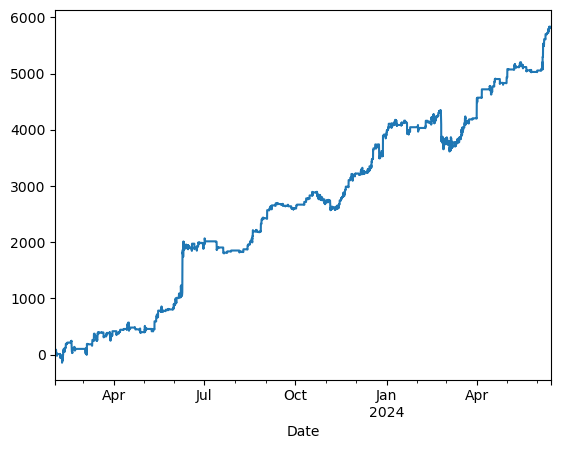

In [10]:
result.pos_pnl['port_val'].plot()

In [11]:
port_ret = (result.pos_pnl['pnl']/1000)
port_ret.mean()*np.sqrt(365*24)/port_ret.std()

3.4505937756969045

In [48]:
# correlation with btc
util.corr_with_btc(port_ret)

0.0160436321433159